In [1]:
import torch
from transformers import CLIPModel, AutoProcessor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# processor = ViTImageProcessor.from_pretrained('google/vit-large-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224').to(device)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
# processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
raw_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# processor =  lambda images: raw_processor(images=images, return_tensors="pt", padding=False, do_resize=False, do_center_crop=False)["pixel_values"]
processor =  lambda images: raw_processor(images=images, return_tensors="pt")["pixel_values"]
text_processor =  lambda text: raw_processor(text=[text], return_tensors="pt", padding=True, truncation=True)
img_processor =  lambda images: raw_processor(images=images, return_tensors="pt")["pixel_values"]
model = model.eval()

2024-06-25 22:10:44.454440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 22:10:45.065146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/data6/wuyinjun/anaconda3/envs/test/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [93]:
from image_utils import *

import utils

patch_count=4

target_img_idx=0

img_file_name_ls=["/data2/wuyinjun/selfdriving.jpg", "/data2/wuyinjun/selfdriving2.png", "/data2/wuyinjun/selfdriving3.png"]

new_raw_img_ls=[]

for img_file_name in img_file_name_ls:
    img = Image.open(img_file_name)
    new_raw_img_ls.append(img)

sample_hash = utils.hashfn(img_file_name_ls)

new_img_file_name_ls = img_file_name_ls#[img_file_name_ls[target_img_idx]]

cl = ConceptLearner(new_raw_img_ls, model, vit_forward, processor, "selfdriving", device)


# cached_img_ls, img_emb, patch_emb, _, bboxes, img_per_patch = cl.get_patches("default", patch_count, sample_hash, img_idx_ls=[target_img_idx], img_file_name_ls=new_img_file_name_ls, method="slic", compute_img_emb=True) #, save_mask_bbox=save_mask_bbox)

cached_img_ls, img_emb, patch_emb, masks, bboxes, img_per_patch = cl.get_patches("default", [4, 8, 16, 64], sample_hash, img_idx_ls=[target_img_idx], img_file_name_ls=new_img_file_name_ls, method="slic", compute_img_emb=True, save_mask_bbox=True)


3it [00:00,  5.94it/s]
3it [00:16,  5.35s/it]


In [94]:
patch_emb_by_img_ls, bboxes = reformat_patch_embeddings(patch_emb, None, img_emb, bbox_ls=bboxes)

100%|██████████| 3/3 [00:00<00:00, 42.85it/s]


[0, 0, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F80A0410790>
[0, 0, 1024, 962]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F80A0410FD0>
[73, 406, 1024, 928]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F80A03FAE20>
[501, 470, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F80A03FAD30>
[0, 753, 593, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F80A0410BB0>
[0, 0, 620, 629]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E85A6AD60>
[0, 0, 1024, 743]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D7070D0>
[8, 465, 809, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D7074F0>
[564, 601, 1024, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D7077C0>
[0, 684, 511, 962]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D7077F0>
[0, 753, 562, 1024]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D707040>
[0, 0, 231, 392]
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D7070A


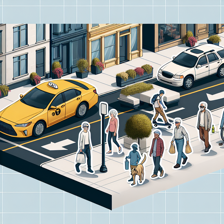
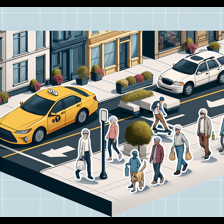
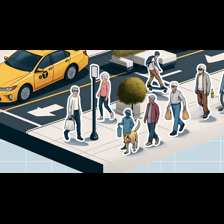
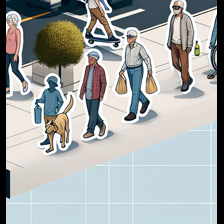
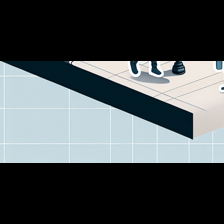
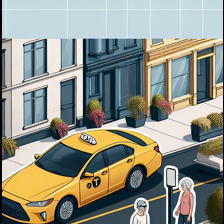
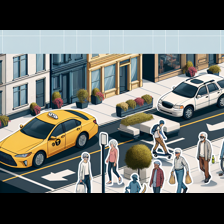
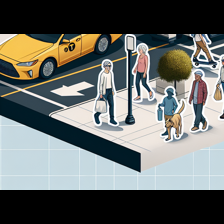
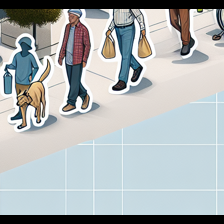
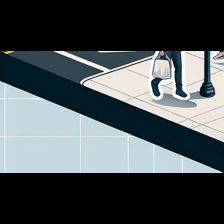
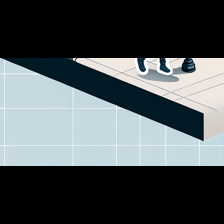
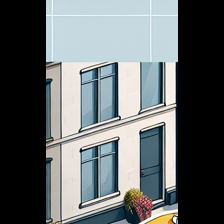
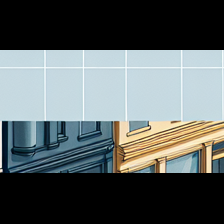
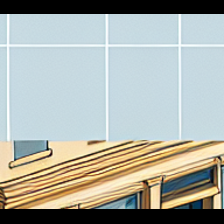
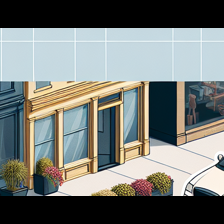
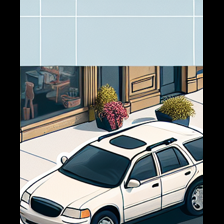
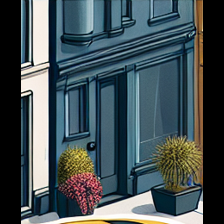
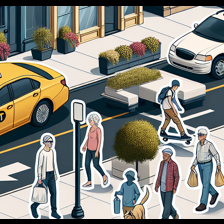
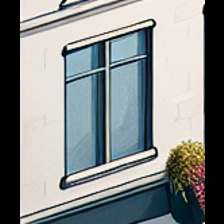
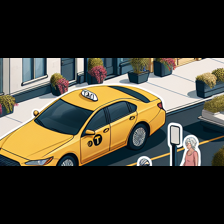
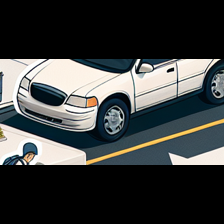
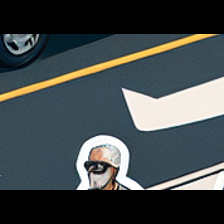
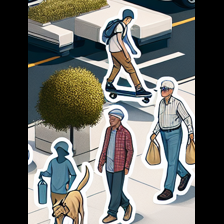
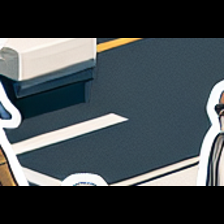
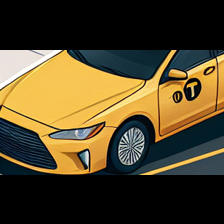
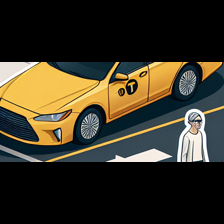
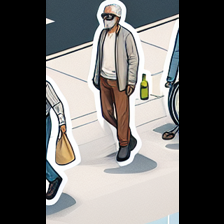
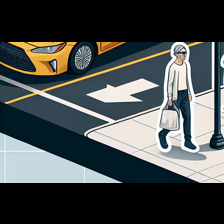
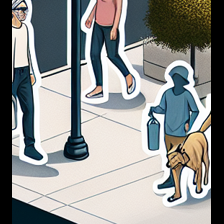
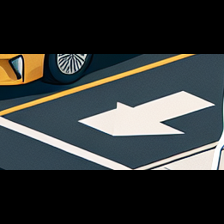
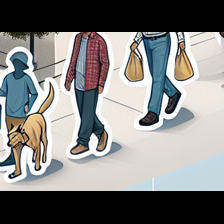
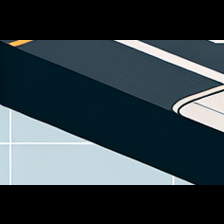
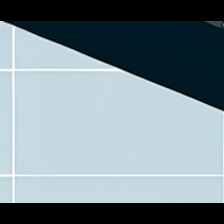
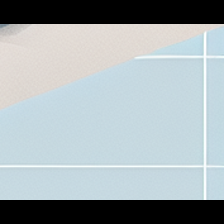
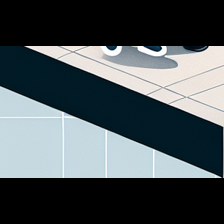
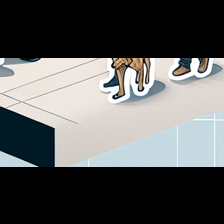
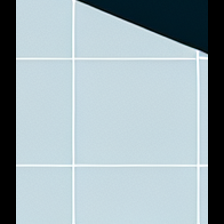
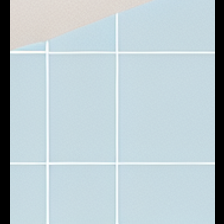
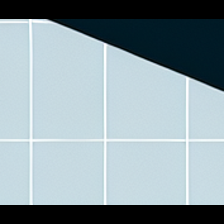
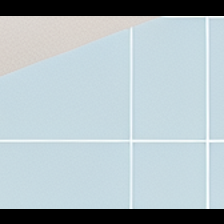
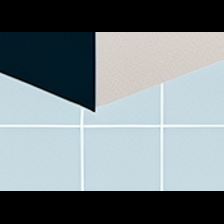
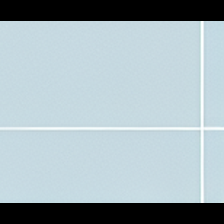
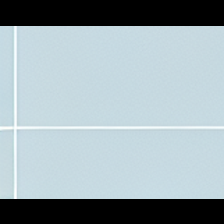


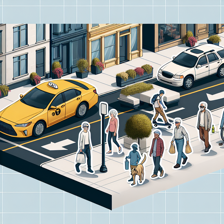
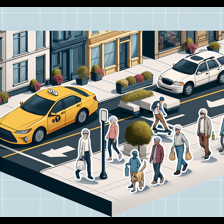
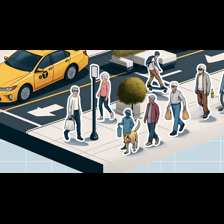
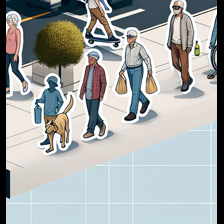
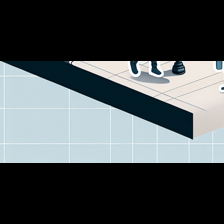
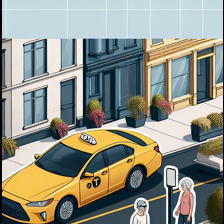
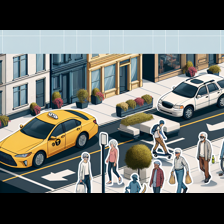
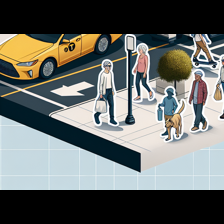
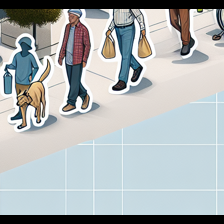
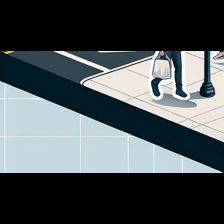
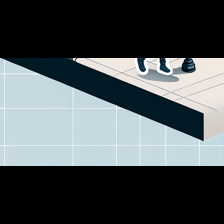
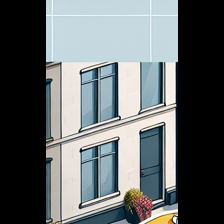
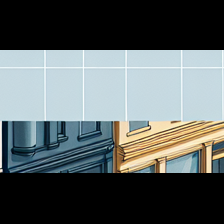
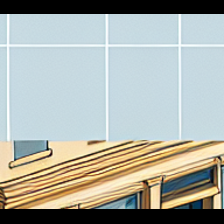
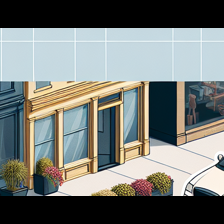
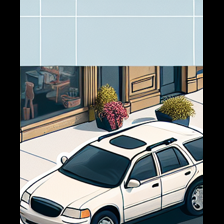
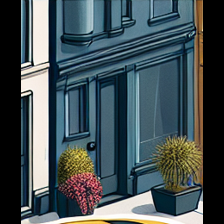
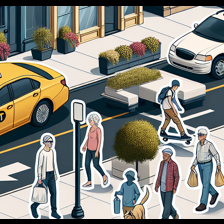
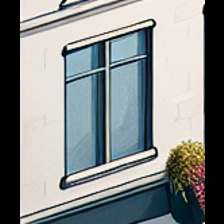
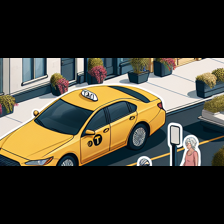
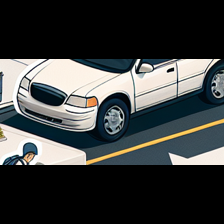
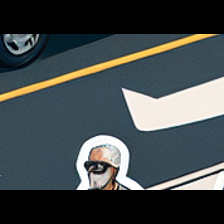
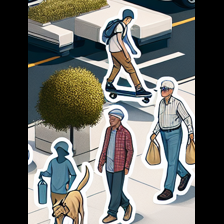
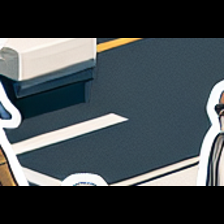
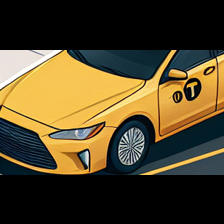
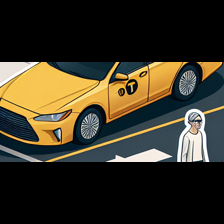
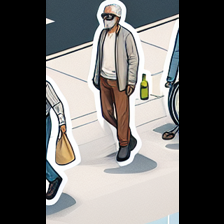
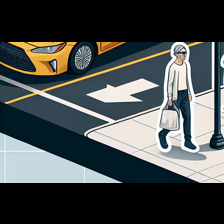
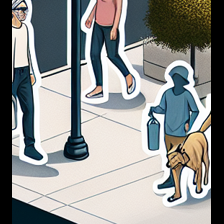
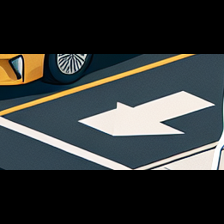
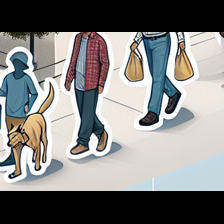
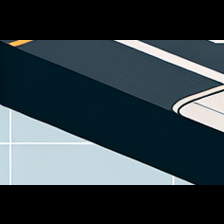
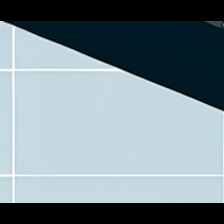
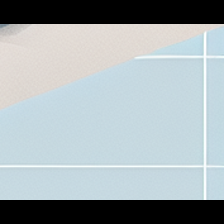
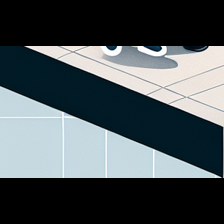
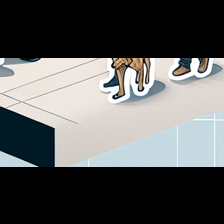
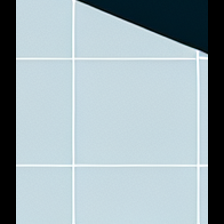
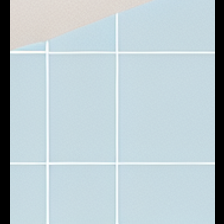
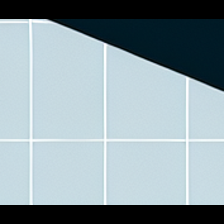
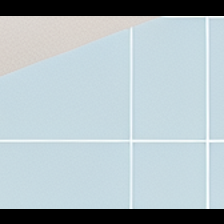
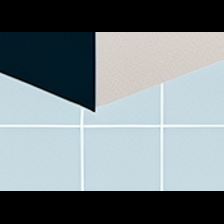
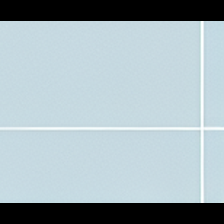
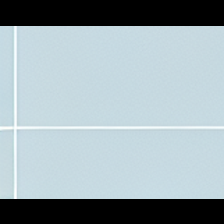

In [95]:
import matplotlib.pyplot as plt
import cv2
import PIL
import ipyplot

image_id = 2

# print(len(masks), len(new_img_file_name_ls), image_id)

# first_mask = masks[0][0]
# print(first_mask)

# print(len(first_mask))

# first_img = new_raw_img_ls[image_id]

first_img = Image.open(new_img_file_name_ls[image_id]).convert("RGB")

first_bbox_ls = bboxes[image_id]

# print(len(bboxes[image_id]))

# print(first_bbox_ls)

masked_image_ls = []

for idx in range(len(first_bbox_ls)):
    first_bbox = first_bbox_ls[idx]
    print(first_bbox)
    masked_image = np.copy(first_img)
    # # print(masked_image.shape)
    # masked_image[first_mask != (idx + 1)] = 255 # Set pixels outside the mask to 0
    curr_patch = PIL.Image.new('RGB', first_img.size)
    curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
    masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
    print(masked_image)
    # masked_image.save(f"crepe_data/partitioned/example_{idx}.jpg")
    # plt.savefig(f"crepe_data/partitioned/example_{idx}.jpg", bbox_inches='tight', pad_inches=0)
    masked_image_ls.append(masked_image)


ipyplot.plot_images(masked_image_ls, max_images=len(first_bbox_ls))   


# masked_image = cv2.rectangle(Image.fromarray(masked_image), (first_bbox[0], first_bbox[1]), (first_bbox[2], first_bbox[3]), (255, 0, 0), 2)

# Display the masked part of the image
# plt.imshow(masked_image)
# plt.axis('off')
# plt.show()

# print(np.unique(first_mask))

In [19]:
first_bbox = first_bbox_ls[56]

os.makedirs("/data2/wuyinjun/selfdriving_exp/", exist_ok=True)

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/black_car.jpg")


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D707FD0>


In [20]:
first_bbox = first_bbox_ls[10]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/taxi.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E85759640>


In [21]:
first_bbox = first_bbox_ls[52]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/people_1.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7D76D700>


In [22]:
first_bbox = first_bbox_ls[52]

curr_patch = PIL.Image.new('RGB', first_img.size)
curr_patch.paste(first_img.copy().crop(first_bbox), box=first_bbox)
masked_image = PIL.ImageOps.pad(curr_patch.crop(first_bbox), (224, 224))
print(masked_image)
masked_image.save(f"/data2/wuyinjun/selfdriving_exp/people_2.jpg")

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E7C690C10>


In [110]:
query="people cross the road"


inputs = text_processor(query)
inputs = {key: val.to(device) for key, val in inputs.items()}
whole_text_features = model.get_text_features(**inputs)
print(whole_text_features.shape)

torch.Size([1, 768])


In [111]:
sim0 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim0)

sim0_2 = torch.nn.functional.cosine_similarity(whole_text_features.cpu().view(1,-1), img_emb[1].cpu().view(1,-1))
print(sim0_2)

tensor([0.1979], grad_fn=<SumBackward1>)
tensor([0.2064], grad_fn=<SumBackward1>)


In [70]:
query1="taxi parking on the street"


inputs = text_processor(query1)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features1 = model.get_text_features(**inputs)
print(text_features1.shape)

torch.Size([1, 768])


In [71]:
sim1 = torch.nn.functional.cosine_similarity(text_features1.cpu().view(1,-1), patch_emb_by_img_ls[0][10].cpu().view(1,-1))
print(sim1)

sim2 = torch.nn.functional.cosine_similarity(text_features1.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim2)

tensor([0.2542], grad_fn=<SumBackward1>)
tensor([0.2178], grad_fn=<SumBackward1>)


In [72]:
query2="black car driving on the road"


inputs = text_processor(query2)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features2 = model.get_text_features(**inputs)
print(text_features2.shape)

torch.Size([1, 768])


In [73]:
sim1 = torch.nn.functional.cosine_similarity(text_features2.cpu().view(1,-1), patch_emb_by_img_ls[0][56].cpu().view(1,-1))
print(sim1)

sim2 = torch.nn.functional.cosine_similarity(text_features2.cpu().view(1,-1), img_emb[0].cpu().view(1,-1))
print(sim2)

tensor([0.2457], grad_fn=<SumBackward1>)
tensor([0.2110], grad_fn=<SumBackward1>)


In [109]:
query3="people cross the streets"


inputs = text_processor(query3)
inputs = {key: val.to(device) for key, val in inputs.items()}
text_features3 = model.get_text_features(**inputs)
print(text_features3.shape)

torch.Size([1, 768])


In [ ]:
sim1 = torch.nn.functional.cosine_similarity(text_features3.cpu().view(1,-1), patch_emb_by_img_ls[0].cpu())
print(sim1)
print(sim1.argmax())
print(sim1.max())

sim2 = torch.nn.functional.cosine_similarity(text_features3.cpu().view(1,-1), patch_emb_by_img_ls[1].cpu())
print(sim2)

tensor([0.1761, 0.2070, 0.2024, 0.1788, 0.1740, 0.1761, 0.2090, 0.1831, 0.1709,
        0.2089, 0.1386, 0.1663, 0.1690, 0.1718, 0.1399, 0.1954, 0.1951, 0.2049,
        0.1948, 0.1781, 0.1798, 0.1826, 0.1498, 0.1711, 0.1608, 0.1444, 0.1585,
        0.1457, 0.1556, 0.1433, 0.1181, 0.1107, 0.1449, 0.1442, 0.1842, 0.1803,
        0.1505, 0.2013, 0.2079, 0.1523, 0.1720, 0.1387, 0.1526, 0.1818, 0.1624,
        0.1710, 0.1479, 0.1751, 0.1792, 0.2123, 0.1557, 0.2035, 0.2217, 0.2131,
        0.1520, 0.1542, 0.1699, 0.1916, 0.2014, 0.1425, 0.1557, 0.1426, 0.2126,
        0.1732, 0.1715, 0.1608, 0.1744, 0.1772, 0.1592, 0.1811, 0.1761],
       grad_fn=<SumBackward1>)
tensor(52)
tensor(0.2217, grad_fn=<MaxBackward1>)
tensor([0.1761], grad_fn=<SumBackward1>)


In [ ]:
import copy
from PIL import Image, ImageDraw
box_width=3

image_path = "/data2/wuyinjun/selfdriving.jpg"
# image_path="/data2/wuyinjun/flickr/flickr30k-images/1000366164.jpg"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
# exp_bbox = copy.copy(first_bbox_ls[11])
# exp_bbox[0] = exp_bbox[0] + 50
# print(exp_bbox)
# print(first_bbox_ls[11])
draw.rectangle(first_bbox_ls[10], outline="red", width=box_width)
# bounding_boxes = [first_bbox_ls[idx] for idx in bbox_ids]
# # Draw the bounding boxes
# for box in bounding_boxes:
#     print(box)
#     draw_dotted_rectangle(draw, box)
    # draw.rectangle(box, outline=box_color, width=box_width)

# draw.rectangle(first_bbox_ls[4], outline="red", width=box_width)    
# draw.rectangle(first_bbox_ls[56], outline="green", width=box_width)
image.save("/data2/wuyinjun/selfdriving_exp/selfdriving_with_bbox.jpg")
image.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Error: no "view" mailcap rules found for type "image/png"
